# Deep Emulator in the Kato-Phillips Case: Postprocessing NN Outputs

IN PROGRESS

We use the trained neural network to apply it to new data. We convert the outputs back to readable data in a state matrix $s_t$.


#### Structure of the Notebook
1. Import Libraries and Load Data
2. Apply Model (Basic)
3. Test Adjusted Models
4. Apply Model (Roll-out)
5. Check Explained Y-Variance
6. Plot and Save

In [ ]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import jax.numpy as jnp
from flax.training.checkpoints import restore_checkpoint
from flax import linen as nn
from mlp import MLP
import unet
from tunax.space import Trajectory
from tunax import Grid

from typing import List, Tuple, TypeAlias
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]

from utils import preprocess_and_generate_labels, traj_from_ds

In [4]:
n_sim = 100 # metadata to handle (.yaml?)
depth = 50
grid = Grid.linear(depth, depth)

In [5]:
# Load state dict and initialize model
checkpoint_dir = os.path.abspath("checkpoints")
params = restore_checkpoint(checkpoint_dir, target=None)
model = MLP(hidden_sizes=[64, 64])

/home/durifa/Documents/deep_emulators/ige_deep_emulators/tunax_env/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [ ]:
# to parallelize over trajectories

def roll_out_from_traj(file_paths, inf_combined_data, norm_factor, model, params):
    # Initialization
    inf_combined_data, _ = preprocess_and_generate_labels(file_paths, norm_factor)
    n_sim = len(file_paths)
    n_time = inf_combined_data.shape[0]//n_sim
    depth = inf_combined_data.shape[2]
    grid = Grid.linear(depth, depth)
    
    original_traj = [None] * n_sim
    deep_traj = [None] * n_sim
    
    # Rollout
    for i in range(n_sim):
        
        # get original trajectory
        data = xr.open_dataset(file_paths[i])
        original_traj[i] = traj_from_ds(data, grid)
        
        # get preprocessed data for the trajectory
        pre_data = np.zeros((n_time+1, 5, depth)) # initial state + n_time following states
        pre_data[:-1] = inf_combined_data[i*n_time:(i+1)*n_time]
        # initial state
        state_t = pre_data[:1] # ! change with reshape function
        
        for t in range(n_time):
            temp_delta = model.apply(params, state_t)
            pre_data[t+1, 0, :] = pre_data[t, 0, :] + temp_delta # roll out
            # no need to postprocess because temp_delta are normalized too
            state_t = pre_data[t+1:t+2] # to change with reshape
        # pre_data temperatures are results of the model
        
        # store ith deep trajectory
        deep_traj[i] = Trajectory(grid=grid, time=original_traj[i].time,
                                  u=original_traj[i].u, v=original_traj[i].v,
                                  t=pre_data[:,0,:]*norm_factor, s=original_traj[i].s)

    return original_traj, deep_traj


In [12]:
data_dir = "data/"  # where simulations files are stored
file_names = [f"traj{i}.nc" for i in range(n_sim)]
file_paths = [os.path.join(data_dir, name) for name in file_names]

# Load application data
app_data = np.load("data/inf_combined_data.npy")
app_labels = np.load("data/inf_labels.npy")

In [14]:
original_traj, deep_traj = roll_out_from_traj(file_paths[:2], app_data, 25., model, params)
# 3 minutes for 100 trajectories with numpy

/home/durifa/Documents/deep_emulators/ige_deep_emulators/utils.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


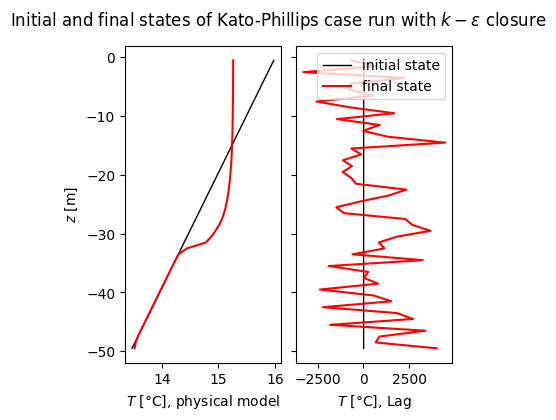

In [15]:
# Plot and compare to actual trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep_lag = deep_traj[sim_index]

zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 2, sharey=True, figsize=(4, 4))
fig, [ax_t, ax_y] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')
ax_y.plot(traj_deep_lag.t[0, :], zr, 'k', linewidth=1, label='initial state')
ax_y.plot(traj_deep_lag.t[-1, :], zr, 'r', label='final state')

ax_t.set_xlabel ('$T$ [°C], physical model')
ax_y.set_xlabel('$T$ [°C], Lag')
ax_t.set_ylabel(r'$z$ [m]')
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_y.legend(framealpha=.8)

plt.show()

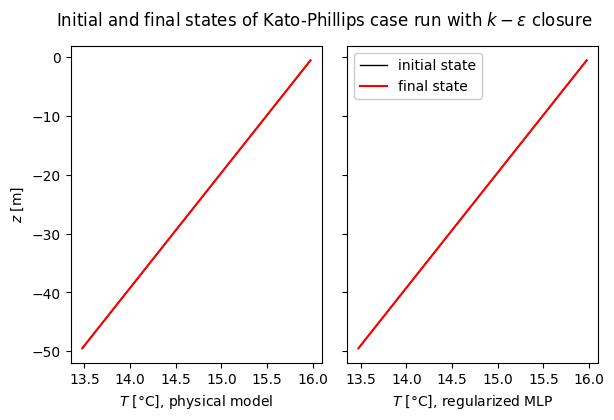

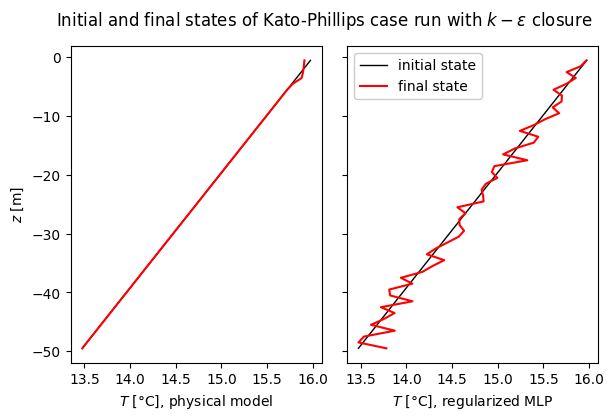

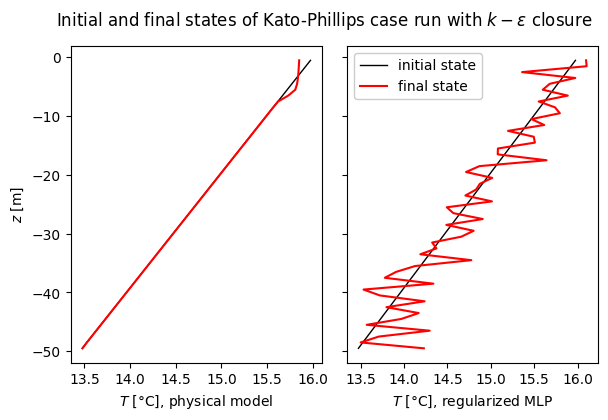

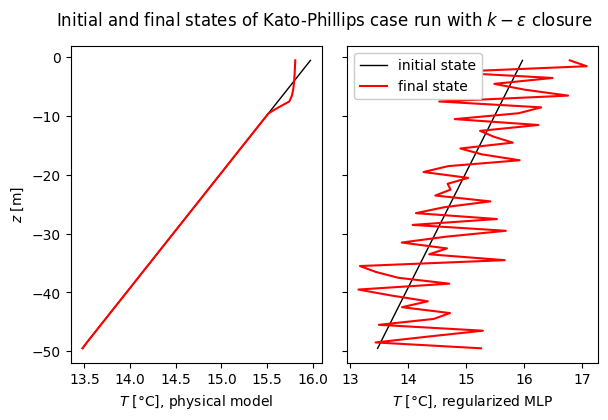

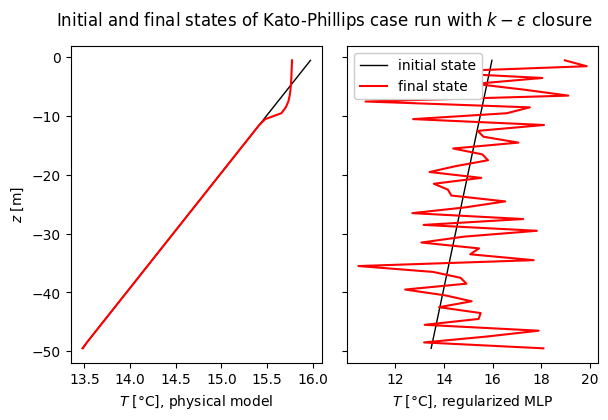

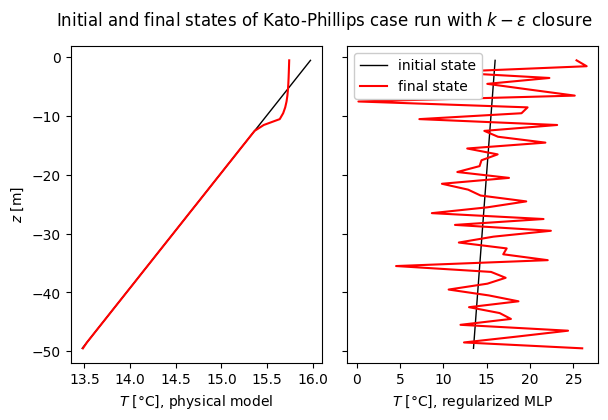

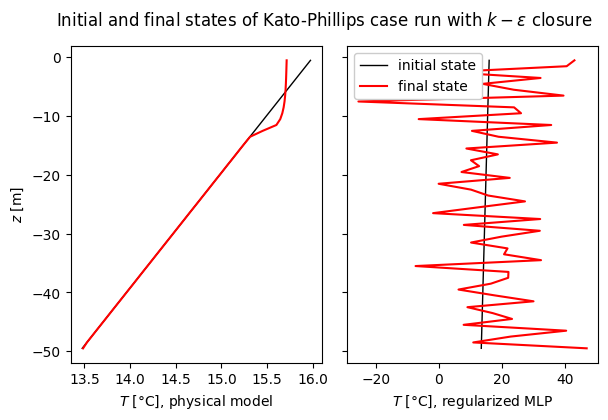

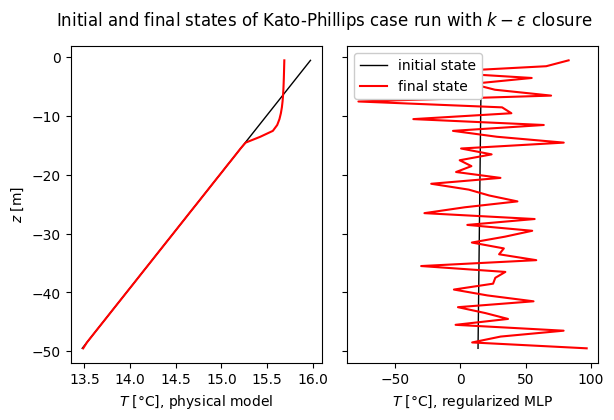

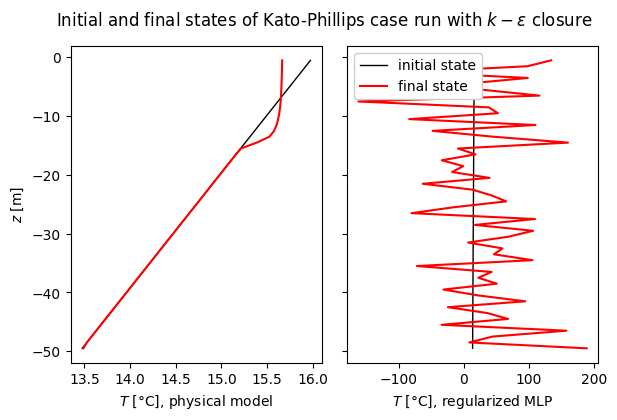

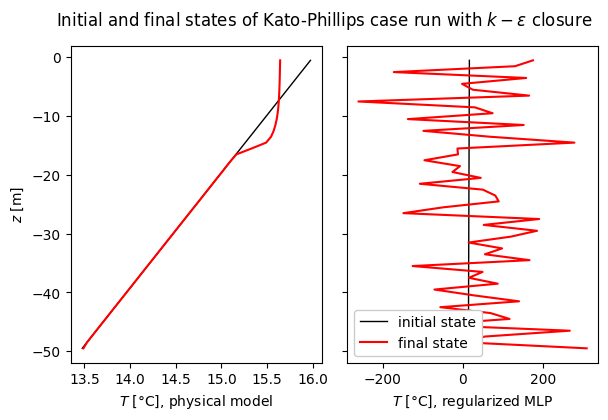

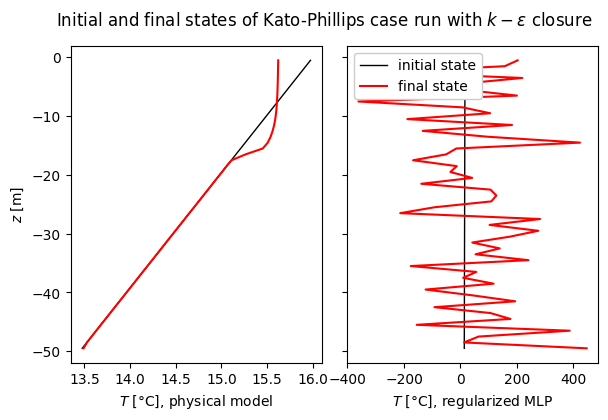

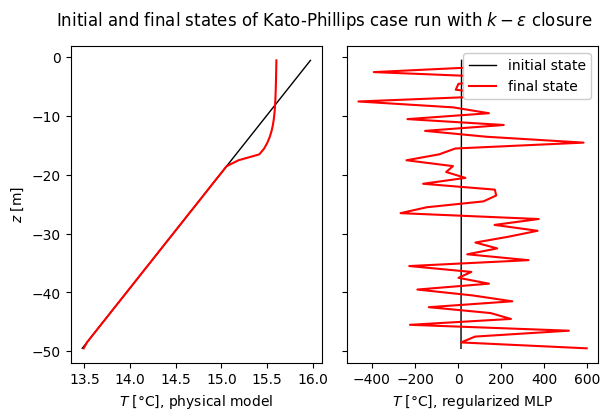

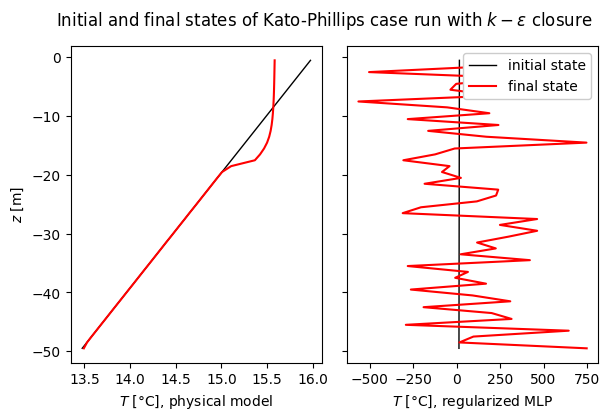

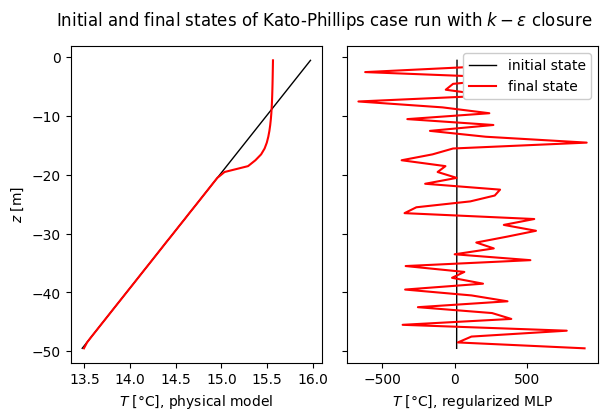

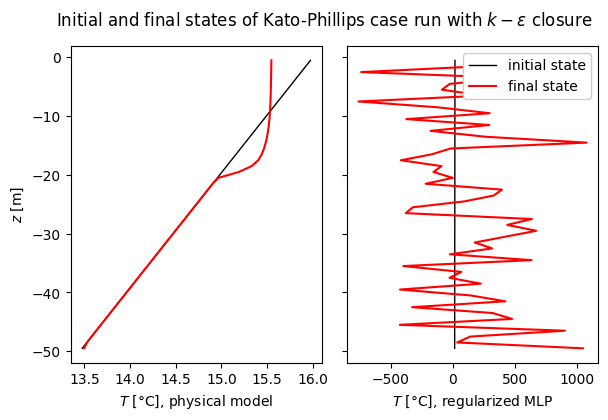

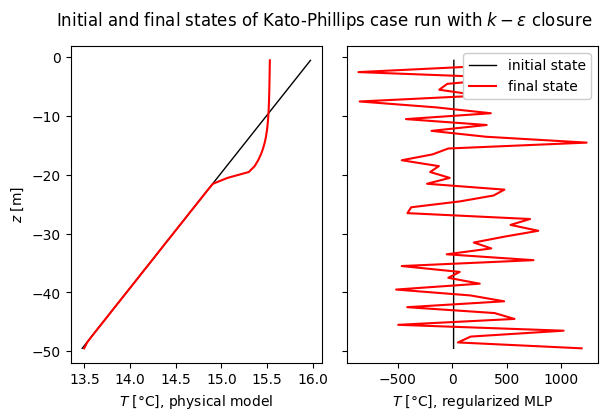

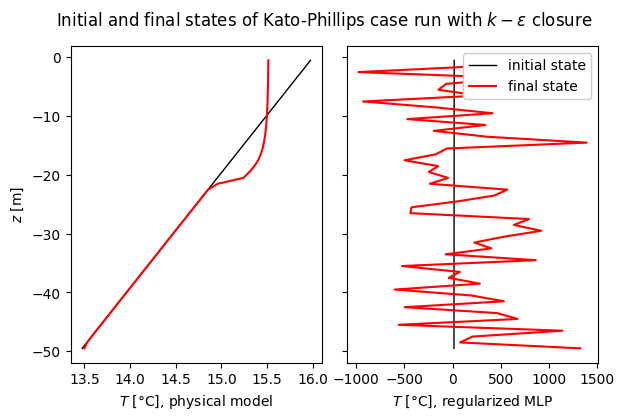

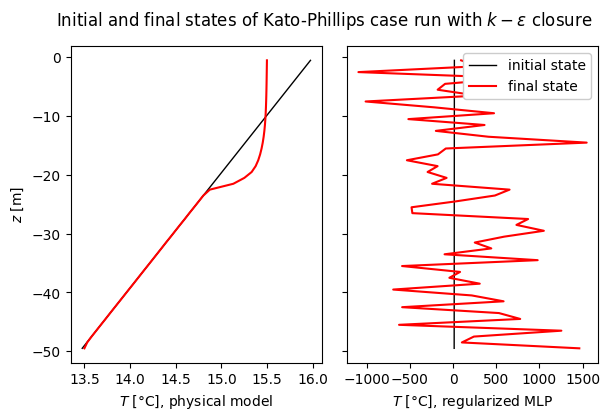

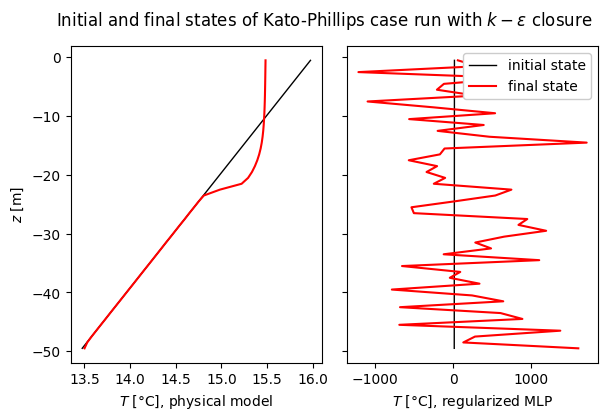

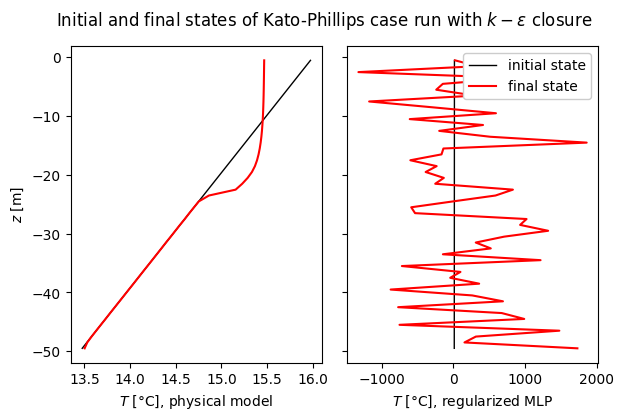

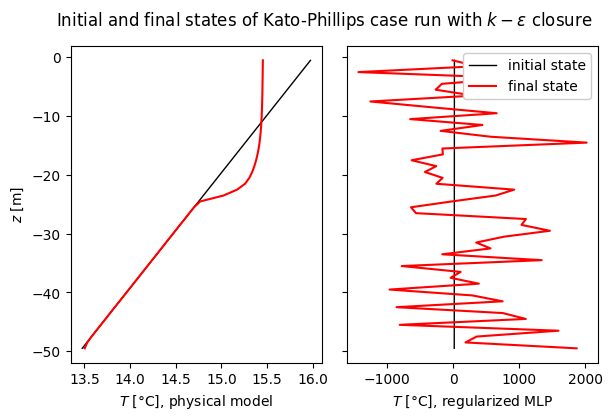

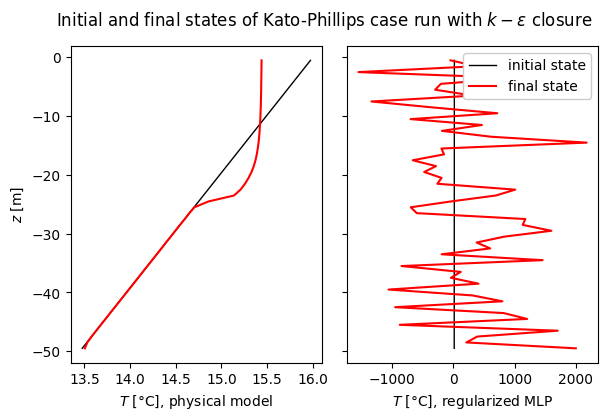

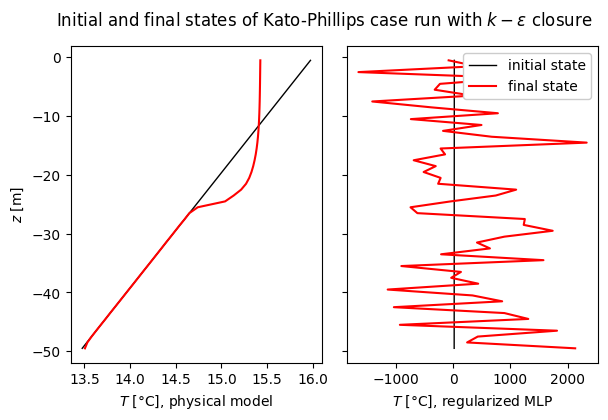

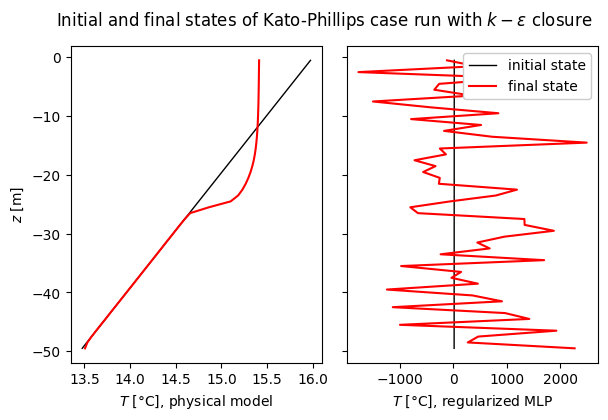

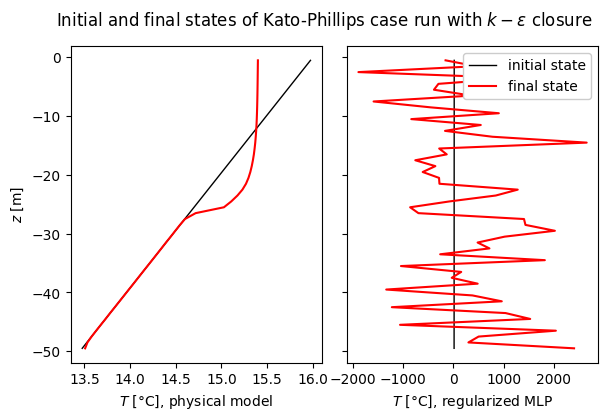

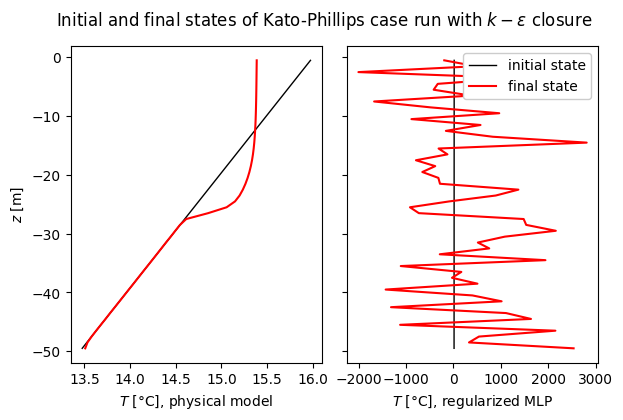

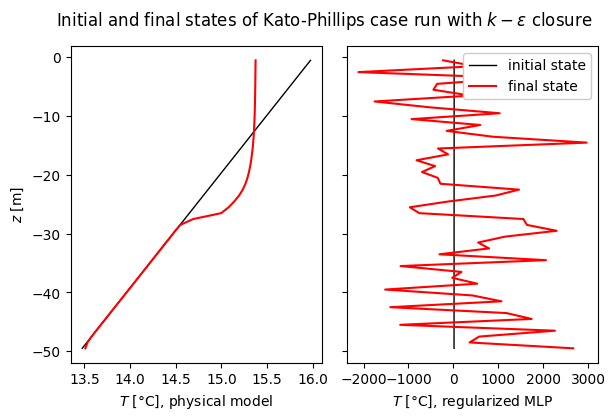

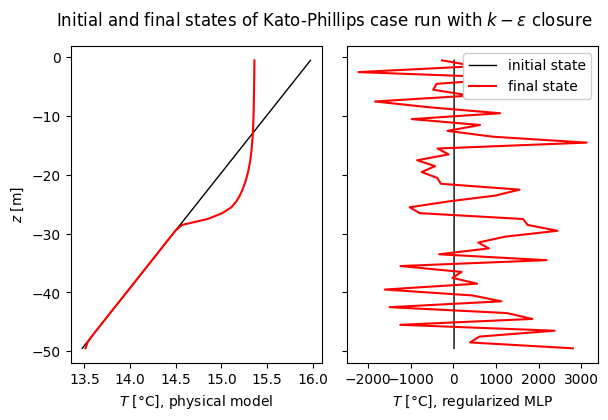

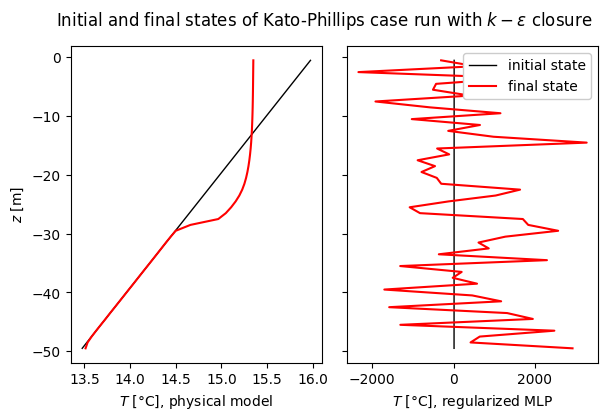

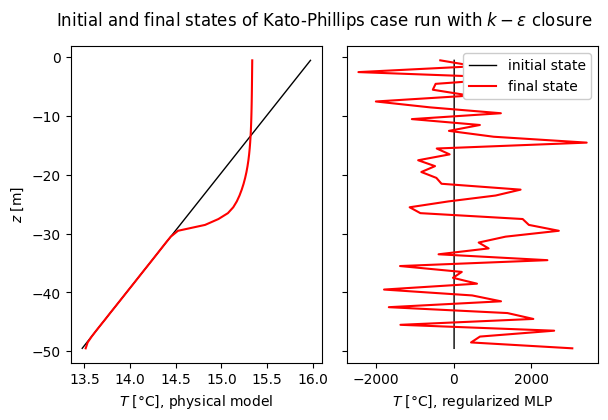

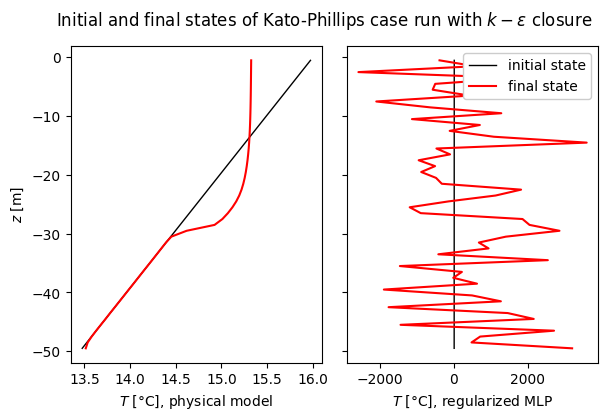

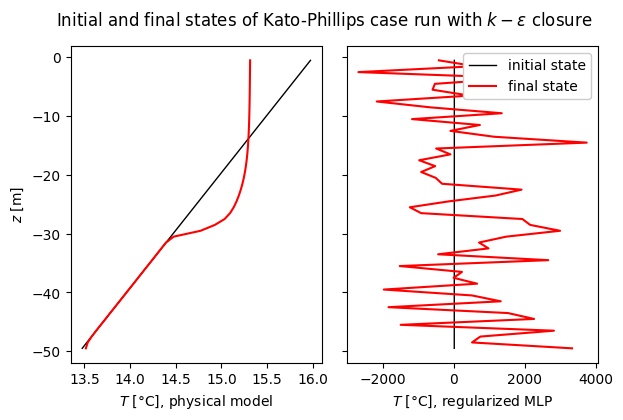

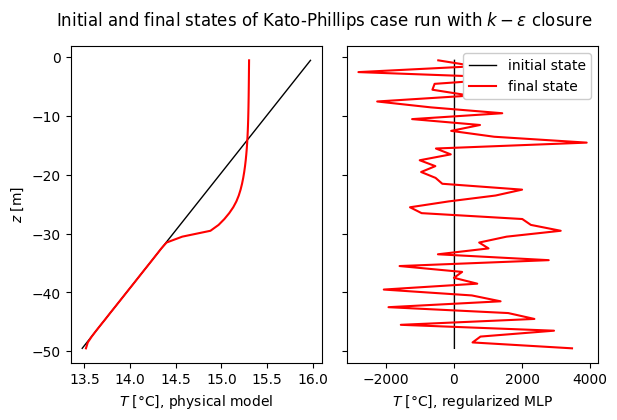

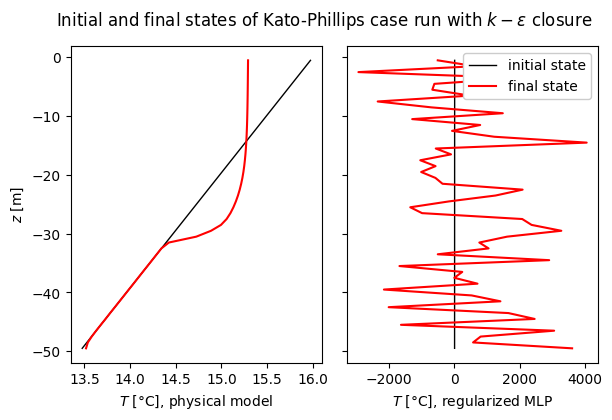

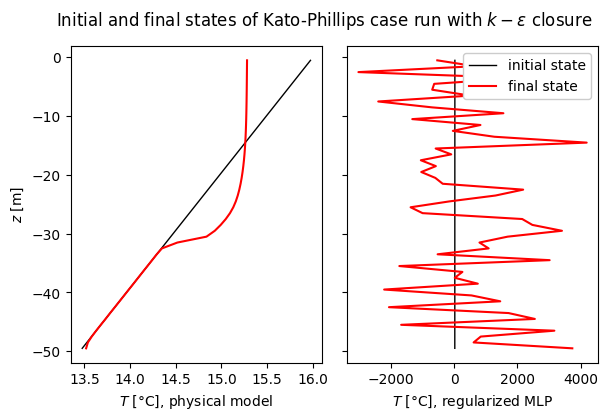

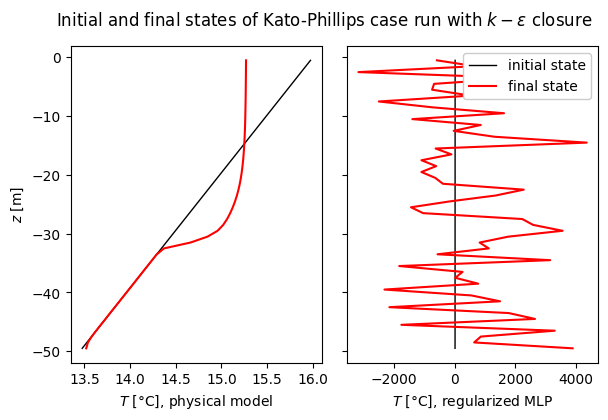

In [16]:
# Track the evolution of the trajectory

sim_index = -1
traj_obs = original_traj[sim_index]
traj_deep = deep_traj[sim_index]
n_time = 359

zr = grid.zr

#for time in range(n_time):
for time in range((n_time+5)//10):
    
    sp: subplot_1D_type = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
    fig, [ax_t, ax_v] = sp
    fig.tight_layout(rect=[0, 0.0, 1, 0.94])
    fig.subplots_adjust(wspace=0.1)
    ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
    ax_t.plot(traj_obs.t[time*10, :], zr, 'r')
    ax_v.plot(traj_deep.t[0, :], zr, 'k', linewidth=1, label='initial state')
    ax_v.plot(traj_deep.t[time*10, :], zr, 'r', label='final state')

    ax_t.set_xlabel ('$T$ [°C], physical model')
    ax_v.set_xlabel('$T$ [°C], regularized MLP')
    ax_t.set_ylabel(r'$z$ [m]')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
    ax_v.legend(framealpha=1.)

    plt.show()